# Setup

In [ ]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

In [ ]:
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

import os
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/Maestria en Data Science/DMEyF/' # reemplazar por directorio base
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
resultados_path = base_path + 'resultados/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104
mes_score= 202106

# agregue sus semillas
semillas = [312389,300007,524287,761839,937081]

data = pd.read_csv(dataset_path + dataset_file)

# Crear el directorio .kaggle
#os.makedirs('/root/.kaggle/', exist_ok=True)

# Mover el archivo kaggle.json desde Google Drive
#shutil.copy(base_path+'kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

# Data quality and drifting

## Data quality - ceros y nulls

In [ ]:
train_data = data[data['foto_mes'] == mes_train]
score_data = data[data['foto_mes'] == mes_score]

train_null_percentage = train_data.isnull().mean() * 100
score_null_percentage = score_data.isnull().mean() * 100

comparison_df = pd.DataFrame({'Train Null Percentage': train_null_percentage, 'Score Null Percentage': score_null_percentage})
comparison_df['diff'] = (comparison_df['Score Null Percentage'] - comparison_df['Train Null Percentage']).abs()

comparison_df_sorted = comparison_df.sort_values('diff', ascending=False)

comparison_df_sorted

,Train Null Percentage,Score Null Percentage,diff
clase_ternaria,0.000000,100.000000,100.000000
mtarjeta_master_descuentos,0.000000,2.682016,2.682016
mtarjeta_visa_descuentos,0.000000,1.784978,1.784978
Master_mpagosdolares,60.002705,58.459691,1.543014
Master_mconsumototal,60.002705,58.459691,1.543014
...,...,...,...
mpayroll,0.000000,0.000000,0.000000
mpayroll2,0.000000,0.000000,0.000000
cpayroll2_trx,0.000000,0.000000,0.000000
ccuenta_debitos_automaticos,0.000000,0.000000,0.000000


In [ ]:
train_zero_percentage = (train_data == 0).mean() * 100
score_zero_percentage = (score_data == 0).mean() * 100

comparison_df_zero = pd.DataFrame({'Train Zero Percentage': train_zero_percentage, 'Score Zero Percentage': score_zero_percentage})

comparison_df_zero['diff_zero_percentage'] = (comparison_df_zero['Score Zero Percentage'] - comparison_df_zero['Train Zero Percentage']).abs()
diff_zero_percentage_sorted = comparison_df_zero.sort_values('diff_zero_percentage',ascending=False)
diff_zero_percentage_sorted


,Train Zero Percentage,Score Zero Percentage,diff_zero_percentage
Master_fultimo_cierre,0.000000,68.891773,68.891773
Visa_fultimo_cierre,0.000000,68.829909,68.829909
cmobile_app_trx,30.885481,23.683859,7.201622
ctarjeta_visa_descuentos,100.000000,93.759553,6.240447
mtarjeta_visa_descuentos,100.000000,93.968801,6.031199
...,...,...,...
tcuentas,0.000000,0.000000,0.000000
cproductos,0.000000,0.000000,0.000000
cliente_antiguedad,0.000000,0.000000,0.000000
cliente_edad,0.000000,0.000000,0.000000


In [ ]:
# prompt: generar una linea que elimine las propiedades Master_fultimo_cierre y Visa_fultimo_cierre de data

data = data.drop(['Master_fultimo_cierre', 'Visa_fultimo_cierre'], axis=1)


## Data Drifting

In [ ]:
def psi(expected, actual, buckets=10):

    def psi_formula(expected_prop, actual_prop):
        result = (actual_prop - expected_prop) * np.log(actual_prop / expected_prop)
        return result

    expected_not_null = expected.dropna()
    actual_not_null = actual.dropna()

    # Crear los bordes de los bins utilizando pd.qcut
    try:
        bin_edges = pd.qcut(expected_not_null, q=buckets, duplicates='drop').unique()
        # Asegurarse de que sean intervalos y extraer los límites
        breakpoints = sorted(set([edge.left for edge in bin_edges] + [edge.right for edge in bin_edges]))
    except Exception as e:
        print(f"Error creating bins: {e}")
        return np.nan

    # Crear histogramas para expected y actual
    expected_counts, _ = np.histogram(expected_not_null, bins=breakpoints)
    actual_counts, _ = np.histogram(actual_not_null, bins=breakpoints)

    # Calcular las proporciones
    expected_prop = expected_counts / len(expected_not_null)
    actual_prop = actual_counts / len(actual_not_null)

    # Calcular PSI para valores no nulos
    psi_not_null = psi_formula(expected_prop, actual_prop).sum()

    # Calcular PSI para valores nulos si es que existen
    psi_null = 0
    if expected.isnull().sum() > 0 and actual.isnull().sum() > 0:
        expected_null_percentage = expected.isnull().mean()
        actual_null_percentage = actual.isnull().mean()
        psi_null = psi_formula(expected_null_percentage, actual_null_percentage)

    return psi_not_null + psi_null



In [ ]:
train_data = data[data['foto_mes'] == mes_train]
score_data = data[data['foto_mes'] == mes_score]

In [ ]:
psi_results = []
for column in train_data.columns:
  if column not in ['foto_mes', 'clase_ternaria']:
    train_variable = train_data[column]
    score_variable = score_data[column]
    psi_value = psi(train_variable, score_variable)
    psi_results.append({'feature': column, 'psi': psi_value})

psi_df = pd.DataFrame(psi_results)
psi_df = psi_df.sort_values('psi', ascending=False)
psi_df


Error creating bins: 'float' object has no attribute 'left'
Error creating bins: 'float' object has no attribute 'left'
Error creating bins: 'float' object has no attribute 'left'
Error creating bins: 'float' object has no attribute 'left'
Error creating bins: 'float' object has no attribute 'left'
Error creating bins: 'float' object has no attribute 'left'


<ipython-input-12-202c9e4017d6>:4: RuntimeWarning: divide by zero encountered in log
  result = (actual_prop - expected_prop) * np.log(actual_prop / expected_prop)
<ipython-input-12-202c9e4017d6>:4: RuntimeWarning: divide by zero encountered in log
  result = (actual_prop - expected_prop) * np.log(actual_prop / expected_prop)


,feature,psi
134,Visa_Finiciomora,inf
113,Master_Finiciomora,inf
51,mpayroll,0.313621
50,cpayroll_trx,0.216031
112,Master_Fvencimiento,0.155537
...,...,...
65,mcajeros_propios_descuentos,NaN
66,ctarjeta_visa_descuentos,NaN
67,mtarjeta_visa_descuentos,NaN
68,ctarjeta_master_descuentos,NaN


Elimino prestamos personales que tiene drifting

In [ ]:
data = data.drop(['mprestamos_personales', 'cprestamos_personales'], axis=1)


# Feature Engineering

In [ ]:
# Añadir nuevas columnas
data['mtarjetas_consumo'] = np.round(data[['mtarjeta_visa_consumo', 'mtarjeta_master_consumo']].sum(axis=1, skipna=True), 1)

data['mbeneficios'] = np.round(data[['mcajeros_propios_descuentos', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos']].sum(axis=1, skipna=True), 1)

data['mingresos'] = np.round(data[['mpayroll', 'mpayroll2', 'mtransferencias_recibidas']].sum(axis=1, skipna=True), 1)


In [ ]:
data = data.drop(columns=[
    'mcajeros_propios_descuentos',
    'mtarjeta_visa_descuentos',
    'mtarjeta_master_descuentos',
])

In [ ]:

# Calcular la diferencia como límite menos consumo para MasterCard
data['diff_master_compra'] = round(data['Master_mlimitecompra'] - data['Master_mconsumospesos'], 2)

# Calcular la diferencia como límite menos consumo para Visa
data['diff_visa_compra'] = round(data['Visa_mlimitecompra'] - data['Visa_mconsumospesos'], 2)

# Calcular la diferencia como consumo menos comisiones
data['diff_comisiones_consumo'] = round(data['mtarjetas_consumo'] - data['mcomisiones_mantenimiento'], 2)

# Calcular la diferencia como consumo menos comisiones
data['diff_comisiones_beneficios'] = round(data['mbeneficios'] - data['mcomisiones_mantenimiento'], 2)

# Visualizar las primeras filas del DataFrame para comprobar los nuevos cálculos
print(data[['diff_master_compra', 'diff_visa_compra', 'diff_comisiones_consumo', 'diff_comisiones_beneficios']].value_counts())



diff_master_compra  diff_visa_compra  diff_comisiones_consumo  diff_comisiones_beneficios
70380.00            70380.00           0.00                     0.00                         90
197064.00           197064.00          0.00                     0.00                         49
70380.00            70380.00          -1774.04                 -1774.04                      45
84456.00            84456.00           0.00                     0.00                         40
112608.00           112608.00          0.00                     0.00                         39
                                                                                             ..
                                       7459.40                  0.00                          1
                                       7299.99                 -1622.81                       1
                                       7207.10                  0.00                          1
                                       7174.90

In [ ]:
# Ordenamos el DataFrame por 'numero_de_cliente' y 'foto_mes' para asegurarnos de que los cálculos se hagan de manera secuencial
data = data.sort_values(by=['numero_de_cliente', 'foto_mes'])

# Función para calcular el porcentaje de cambio
def calc_percentage_change(x):
    rolling_avg = x.rolling(window=2).mean().shift(1)  # Promedio de los 2 meses anteriores
    return ((x - rolling_avg) / rolling_avg * 100).fillna(0)  # Calculo del porcentaje y manejo de NaN

# Calculamos el porcentaje de variación para cada columna relevante
columns_to_calculate = ['mcuentas_saldo', 'mpayroll', 'mcomisiones', 'mbeneficios', 'mingresos', 'mtarjetas_consumo']

for column in columns_to_calculate:
    data[f'pct_change_{column}'] = data.groupby('numero_de_cliente')[column].transform(calc_percentage_change)

# Visualizar el DataFrame con las nuevas columnas de porcentaje de variación
print(data.head())


        numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
632668          249221109    202101               1            0         0   
632669          249221109    202102               1            0         0   
632670          249221109    202103               1            0         0   
632671          249221109    202104               1            0         0   
632672          249221109    202105               1            0         0   

        cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
632668            61                 300        1664.94              17994.40   
632669            61                 301        1002.92              18337.34   
632670            61                 302         769.74              18596.58   
632671            62                 303        1532.79              19935.00   
632672            62                 304        1804.14              20862.15   

        mcomisiones  ...  diff_master_compra

In [ ]:
data.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,diff_master_compra,diff_visa_compra,diff_comisiones_consumo,diff_comisiones_beneficios,pct_change_mcuentas_saldo,pct_change_mpayroll,pct_change_mcomisiones,pct_change_mbeneficios,pct_change_mingresos,pct_change_mtarjetas_consumo
632668,249221109,202101,1,0,0,61,300,1664.94,17994.40,1605.81,...,508256.52,430042.79,150291.8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
632669,249221109,202102,1,0,0,61,301,1002.92,18337.34,1312.91,...,536514.64,539054.48,53856.7,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
632670,249221109,202103,1,0,0,61,302,769.74,18596.58,1662.56,...,540447.84,569094.41,47424.2,4217.6,-25.096774,81.818182,13.923912,inf,25.082508,-53.539507
632671,249221109,202104,1,0,0,62,303,1532.79,19935.00,1899.52,...,558355.10,570111.43,55586.7,0.0,123.966158,-83.333333,27.678652,-100.0,-30.559168,9.767390
632672,249221109,202105,1,0,0,62,304,1804.14,20862.15,2693.91,...,555335.73,574332.65,64944.2,0.0,-78.024524,122.222222,51.254885,-100.0,47.329728,26.091899


## Deciles y cambio de decil

In [ ]:
def assign_deciles(data, variable, num_deciles=10):
    # Creamos una nueva columna decil_[variable] donde asignamos el decil
    decil_col = f'decil_{variable}'
    data[decil_col] = pd.qcut(data[variable], q=num_deciles, labels=False, duplicates='drop') + 1
    return data

def calculate_decil_change(data, variable, groupby_column='numero_de_cliente'):
    decil_col = f'decil_{variable}'
    decil_change_col = f'decil_change_{variable}'

    # Ordenamos los datos por cliente y mes
    data = data.sort_values(by=[groupby_column, 'foto_mes'])

    # Calculamos la diferencia entre deciles del mes actual y el mes anterior
    data[decil_change_col] = data.groupby(groupby_column)[decil_col].diff()

    return data

variables = ['mpayroll', 'mtarjetas_consumo', 'mingresos', 'mrentabilidad', 'mcomisiones_mantenimiento']

for variable in variables:
    # Asignar los deciles para cada variable
    data = assign_deciles(data, variable)

    # Calcular el cambio de decil entre meses
    data = calculate_decil_change(data, variable)


In [ ]:
data.to_csv(f'{dataset_path}competencia_01_feats_2.csv', index=False)

In [ ]:
data.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,decil_mpayroll,decil_change_mpayroll,decil_mtarjetas_consumo,decil_change_mtarjetas_consumo,decil_mingresos,decil_change_mingresos,decil_mrentabilidad,decil_change_mrentabilidad,decil_mcomisiones_mantenimiento,decil_change_mcomisiones_mantenimiento
632668,249221109,202101,1,0,0,61,300,1664.94,17994.40,1605.81,...,5,NaN,9,NaN,8,NaN,6,NaN,1,NaN
632669,249221109,202102,1,0,0,61,301,1002.92,18337.34,1312.91,...,4,-1.0,7,-2.0,9,1.0,5,-1.0,1,0.0
632670,249221109,202103,1,0,0,61,302,769.74,18596.58,1662.56,...,6,2.0,7,0.0,9,0.0,5,0.0,1,0.0
632671,249221109,202104,1,0,0,62,303,1532.79,19935.00,1899.52,...,2,-4.0,7,0.0,8,-1.0,6,1.0,1,0.0
632672,249221109,202105,1,0,0,62,304,1804.14,20862.15,2693.91,...,6,4.0,8,1.0,9,1.0,7,1.0,1,0.0


# Gradient Boosting Decision Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.


Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [ ]:
data.pct_change_mtarjetas_consumo.value_counts()

,count
pct_change_mtarjetas_consumo,
0.000000,427595
-100.000000,9483
inf,3869
100.000000,1454
14.172969,40
...,...
13.103660,1
6.107027,1
-2.863861,1


In [ ]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [ ]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [ ]:

mes_train = 202102
mes_test = 202104
mes_score= 202106


In [ ]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [ ]:
# Option 1: Replace NaN, inf, and -inf with a constant (e.g., 0 or the column mean)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)


In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

Vamos a utilizar el algoritmo directamente, sin pasar por *scikit-learn*. Sin embargo, si algún alumno lo prefiere, puede optar por usar el *wrapper* de sklearn para este caso.

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [ ]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [ ]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

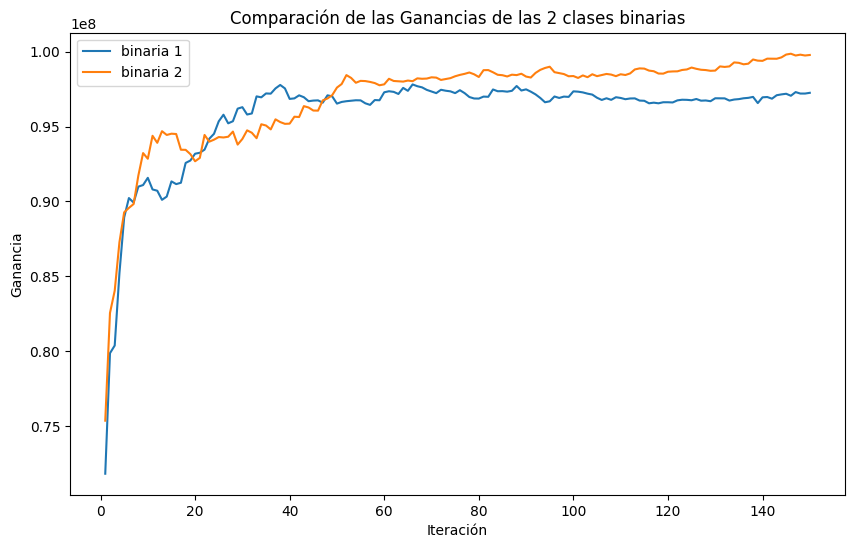

In [ ]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


num bust round - poner un numero alto (10k) y poner el early stop

In [ ]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3) # más bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1,
        'early_stopping_round': int(50 + 5 / learning_rate)  # Mueve esto aquí
    }

    train_data = lgb.Dataset(X_train,
                             label=y_train_binaria2,  # elegir la clase
                             weight=w_train)

    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=10000,  # modificar, subir y subir...
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )

    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_603_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-12 13:13:54,383] Using an existing study with name 'exp_603_lgbm' instead of creating a new one.


In [ ]:
# study.optimize(objective, n_trials=200) # queda cometado, cargo directo el ultimo estudio

[I 2024-10-12 13:16:08,118] Trial 93 finished with value: 104678000.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.0466548699192426, 'min_data_in_leaf': 618, 'feature_fraction': 0.32017558531365004, 'bagging_fraction': 0.5463985102112981}. Best is trial 69 with value: 105294000.0.
[I 2024-10-12 13:18:13,268] Trial 94 finished with value: 104727000.0 and parameters: {'num_leaves': 50, 'learning_rate': 0.04968567934615319, 'min_data_in_leaf': 799, 'feature_fraction': 0.43011943765029387, 'bagging_fraction': 0.49172477695849504}. Best is trial 69 with value: 105294000.0.
[I 2024-10-12 13:20:41,110] Trial 95 finished with value: 103362000.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.0376982074890034, 'min_data_in_leaf': 625, 'feature_fraction': 0.429348399837867, 'bagging_fraction': 0.458359158476904}. Best is trial 69 with value: 105294000.0.
[I 2024-10-12 13:22:17,375] Trial 96 finished with value: 103243000.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.0682

KeyboardInterrupt: 

Analizamos los resultados as usual

In [ ]:

storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_603_lgbm"


In [ ]:
# Cargar el estudio desde la base de datos
study = optuna.load_study(study_name=study_name, storage=storage_name)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
# Filtrar las pruebas para eliminar aquellas sin valor
valid_trials = [trial for trial in study.trials if trial.value is not None]

# Ordenar las pruebas válidas por su valor
sorted_trials = sorted(valid_trials, key=lambda t: t.value)

# Comprobar que hay suficientes pruebas antes de acceder a índices específicos
if len(sorted_trials) >= 5:
    # Obtener las cinco mejores pruebas
    first_best_trial = sorted_trials[0]   # mejor
    second_best_trial = sorted_trials[1]  # segundo mejor
    third_best_trial = sorted_trials[2]   # tercer mejor
    fourth_best_trial = sorted_trials[3]  # cuarto mejor
    fifth_best_trial = sorted_trials[4]   # quinto mejor

    # Imprimir detalles sobre las mejores pruebas
    print(f"First best trial:\n  Value: {first_best_trial.value}\n  Params: {first_best_trial.params}")
    print(f"Second best trial:\n  Value: {second_best_trial.value}\n  Params: {second_best_trial.params}")
    print(f"Third best trial:\n  Value: {third_best_trial.value}\n  Params: {third_best_trial.params}")
    print(f"Fourth best trial:\n  Value: {fourth_best_trial.value}\n  Params: {fourth_best_trial.params}")
    print(f"Fifth best trial:\n  Value: {fifth_best_trial.value}\n  Params: {fifth_best_trial.params}")
else:
    print("No hay suficientes pruebas válidas para mostrar los mejores resultados.")



First best trial:
  Value: 87206000.0
  Params: {'num_leaves': 68, 'learning_rate': 0.26923060060632215, 'min_data_in_leaf': 180, 'feature_fraction': 0.6869112070660447, 'bagging_fraction': 0.4094781905553787}
Second best trial:
  Value: 88088000.0
  Params: {'num_leaves': 14, 'learning_rate': 0.29695016887660536, 'min_data_in_leaf': 486, 'feature_fraction': 0.20289892767683376, 'bagging_fraction': 0.37036086410909885}
Third best trial:
  Value: 93408000.0
  Params: {'num_leaves': 20, 'learning_rate': 0.12775066477125863, 'min_data_in_leaf': 7, 'feature_fraction': 0.2436834691614349, 'bagging_fraction': 0.8838243458183073}
Fourth best trial:
  Value: 93639000.0
  Params: {'num_leaves': 46, 'learning_rate': 0.29410839704979763, 'min_data_in_leaf': 844, 'feature_fraction': 0.5912833295473046, 'bagging_fraction': 0.6731376592141998}
Fifth best trial:
  Value: 94157000.0
  Params: {'num_leaves': 48, 'learning_rate': 0.2658827594015044, 'min_data_in_leaf': 766, 'feature_fraction': 0.4452812

In [ ]:
# best_iter = study.best_trial.user_attrs["best_iter"]
# print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
# params = {
#     'objective': 'binary',
#     'boosting_type': 'gbdt',
#     'first_metric_only': True,
#     'boost_from_average': True,
#     'feature_pre_filter': False,
#     'max_bin': 31,
#     'num_leaves': study.best_trial.params['num_leaves'],
#     'learning_rate': study.best_trial.params['learning_rate'],
#     'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
#     'feature_fraction': study.best_trial.params['feature_fraction'],
#     'bagging_fraction': study.best_trial.params['bagging_fraction'],
#     'seed': semillas[0],
#     'verbose': 0
# }

# train_data = lgb.Dataset(X_train,
#                           label=y_train_binaria2,
#                           weight=w_train)

# model = lgb.train(params,
#                   train_data,
#                   num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 93


In [ ]:
# Define a function to train the model using the parameters from a given trial
def train_model_with_trial_params(trial, X_train, y_train_binaria2, w_train, semillas):
    iterations = trial.user_attrs.get("best_iter")
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': trial.params['num_leaves'],
        'learning_rate': trial.params['learning_rate'],
        'min_data_in_leaf': trial.params['min_data_in_leaf'],
        'feature_fraction': trial.params['feature_fraction'],
        'bagging_fraction': trial.params['bagging_fraction'],
        'seed': semillas[0],
        'verbose': 0
    }

    train_data = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

    # Train the model using the trial parameters
    model = lgb.train(params, train_data, num_boost_round=iterations)

    return model

# Train the models using second and third best trial parameters
model_first_best = train_model_with_trial_params(first_best_trial, X_train, y_train_binaria2, w_train, semillas)
model_second_best = train_model_with_trial_params(second_best_trial, X_train, y_train_binaria2, w_train, semillas)
model_third_best = train_model_with_trial_params(third_best_trial, X_train, y_train_binaria2, w_train, semillas)
model_fourth_best = train_model_with_trial_params(fourth_best_trial, X_train, y_train_binaria2, w_train, semillas)
model_fifth_best = train_model_with_trial_params(fifth_best_trial, X_train, y_train_binaria2, w_train, semillas)


In [ ]:
train_final_data = data[(data['foto_mes'] == 202102) & (data['foto_mes'] == 202103) & (data['foto_mes'] == 202104)]

X_train_final = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_final_binaria1 = train_data['clase_binaria1']
y_train_final_binaria2 = train_data['clase_binaria2']
w_train_final = train_data['clase_peso']


In [ ]:
# Train the models using second and third best trial parameters
model_first_best_final = train_model_with_trial_params(first_best_trial, X_train_final, y_train_final_binaria2, w_train_final, semillas)
model_second_best_final = train_model_with_trial_params(second_best_trial, X_train_final, y_train_final_binaria2, w_train_final, semillas)
model_third_best_final = train_model_with_trial_params(third_best_trial, X_train_final, y_train_final_binaria2, w_train_final, semillas)
model_fourth_best_final = train_model_with_trial_params(fourth_best_trial, X_train_final, y_train_final_binaria2, w_train_final, semillas)
model_fifth_best_final = train_model_with_trial_params(fifth_best_trial, X_train_final, y_train_final_binaria2, w_train_final, semillas)

In [ ]:
model_first_best_final.save_model(modelos_path + f'lgb_603_final_1.txt')
model_second_best_final.save_model(modelos_path + f'lgb_603_final_2.txt')
model_third_best_final.save_model(modelos_path + f'lgb_603_final_3.txt')
model_fourth_best_final.save_model(modelos_path + f'lgb_603_final_4.txt')
model_fifth_best_final.save_model(modelos_path + f'lgb_603_final_5.txt')

Observamos la variables más importantes para el modelo:

In [ ]:
models = [model_first_best, model_second_best, model_third_best, model_fourth_best, model_fifth_best]

for model in models:
  lgb.plot_importance(model, figsize=(10, 20))
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [ ]:
for model in models:
  importances = model.feature_importance()
  feature_names = X_train.columns.tolist()
  importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
  importance_df = importance_df.sort_values('importance', ascending=False)
  importance_df[importance_df['importance'] > 0]


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model_first_best.save_model(modelos_path + f'lgb_603_1.txt')
model_second_best.save_model(modelos_path + f'lgb_603_2.txt')
model_third_best.save_model(modelos_path + f'lgb_603_3.txt')
model_fourth_best.save_model(modelos_path + f'lgb_603_4.txt')
model_fifth_best.save_model(modelos_path + f'lgb_603_5.txt')

Y recuperar el mismo desde ese formato

medimos ganancias de los modelos

In [ ]:

y_pred_lgm_first = model_first_best.predict(X_test)
y_pred_lgm_second = model_second_best.predict(X_test)
y_pred_lgm_third= model_third_best.predict(X_test)
y_pred_lgm_fourth= model_fourth_best.predict(X_test)
y_pred_lgm_fifth= model_fifth_best.predict(X_test)

# y_pred_lgm_first_final = model_first_best_final.predict(X_test)
# y_pred_lgm_second_final = model_second_best_final.predict(X_test)
# y_pred_lgm_third_final= model_third_best_final.predict(X_test)
# y_pred_lgm_fourth_final= model_fourth_best_final.predict(X_test)
# y_pred_lgm_fifth_final= model_fifth_best_final.predict(X_test)

In [ ]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

# print("Ganancia RF:", ganancia_prob(y_pred_rf, y_test_binaria1))
print("Ganancia LGBM1:", ganancia_prob(y_pred_lgm_first, y_test_binaria1))
print("Ganancia LGBM2:", ganancia_prob(y_pred_lgm_second, y_test_binaria1))
print("Ganancia LGBM3:", ganancia_prob(y_pred_lgm_third, y_test_binaria1))
print("Ganancia LGBM4:", ganancia_prob(y_pred_lgm_fourth, y_test_binaria1))
print("Ganancia LGBM5:", ganancia_prob(y_pred_lgm_fifth, y_test_binaria1))


Ganancia LGBM1: 99421000.0
Ganancia LGBM2: 114835000.0
Ganancia LGBM3: 122206000.0
Ganancia LGBM4: 126259000.0
Ganancia LGBM5: 124705000.0


Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

In [ ]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"lgbm1":y_pred_lgm_first, "lgbm2":y_pred_lgm_second,  "lgbm3":y_pred_lgm_third, "lgbm4":y_pred_lgm_fourth, "lgbm5":y_pred_lgm_fifth}
rows = []
for private_index, public_index in sss_futuro.split(X_test, y_test_binaria1):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria1.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria1.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)


In [ ]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

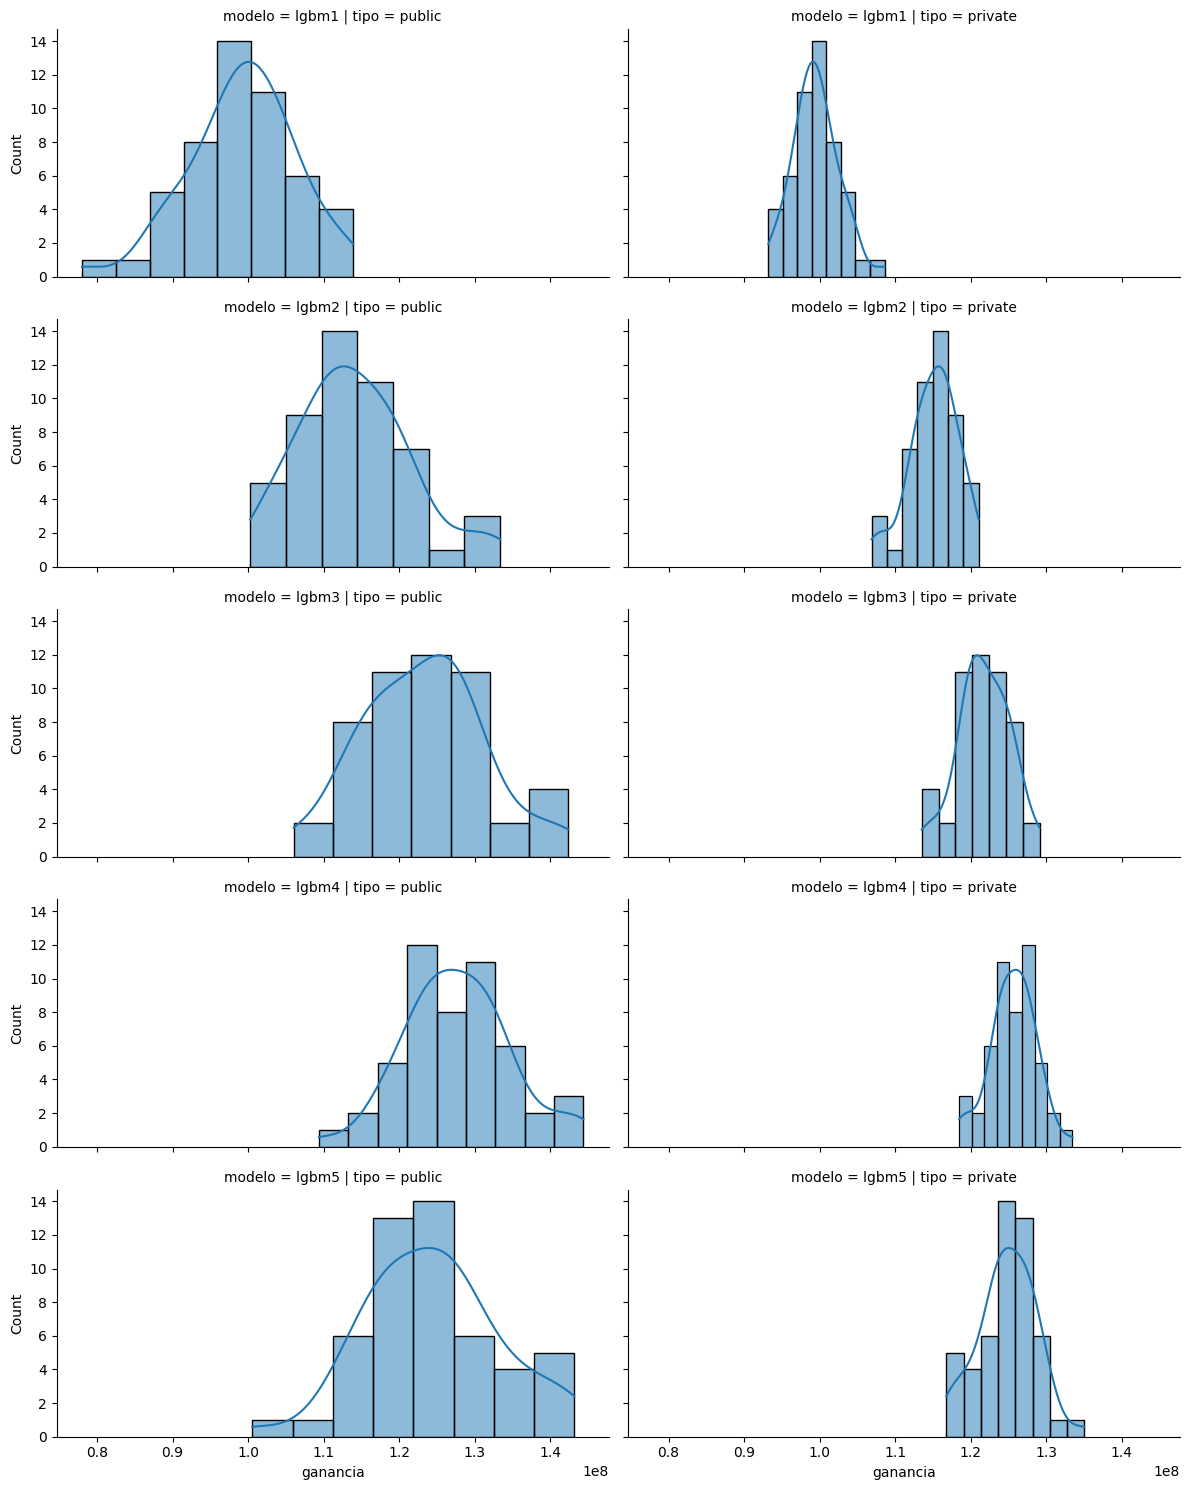

In [ ]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()


Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

In [ ]:
df = pd.DataFrame()
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])

best_private,lgbm3_private,lgbm4_private,lgbm5_private
best_public,,,
lgbm2_public,0,1,0
lgbm3_public,0,6,1
lgbm4_public,1,15,14
lgbm5_public,0,12,0


In [ ]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm_fifth)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm_fifth[idx]

ganancia_cum = np.cumsum(ganancia)


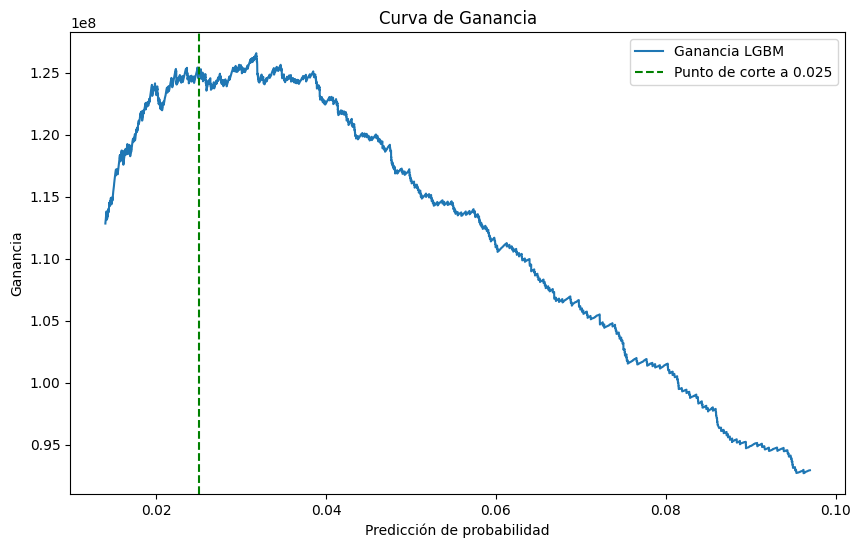

In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

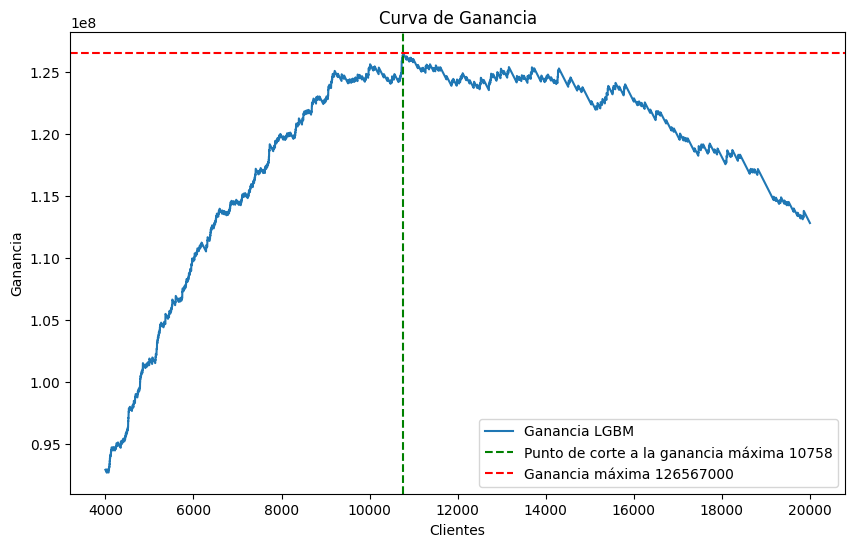

In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Lo que significa que la cantidad de envíos que maximiza la ganancia es 12601. > en el otro modelo base de la clase, con otra semilla

Claro, estamos haciendo trampa. No nunca vamos a contar con datos del futuro para determinar este punto de corte...  o sí?

En nuestro caso, si contamos con una pequeña ventana de datos del futuro, el **leaderboard público**.

Realicemos un análisis para determinar si el leaderboard puede ayudarnos a identificar el punto de corte óptimo que maximice la ganancia en el conjunto de datos privado.

En la siguiente función cambie la semilla para evaluar como cambia los **leaderboards**

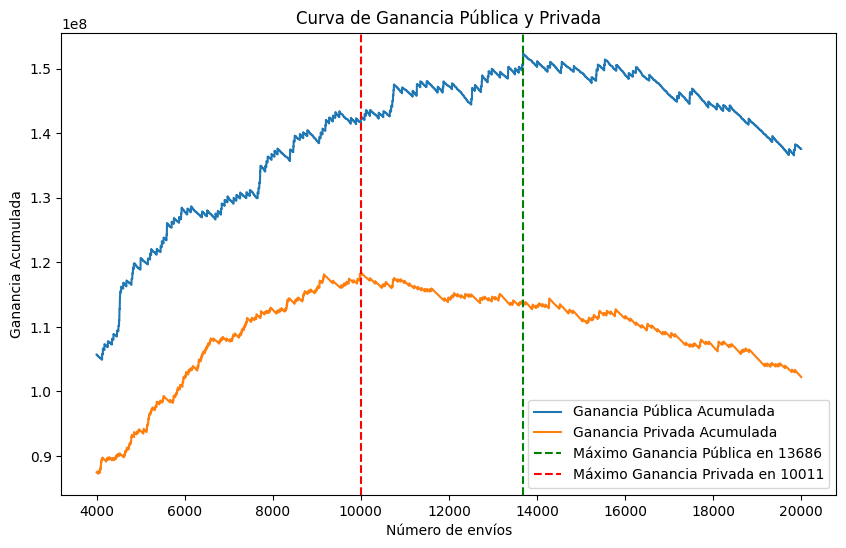

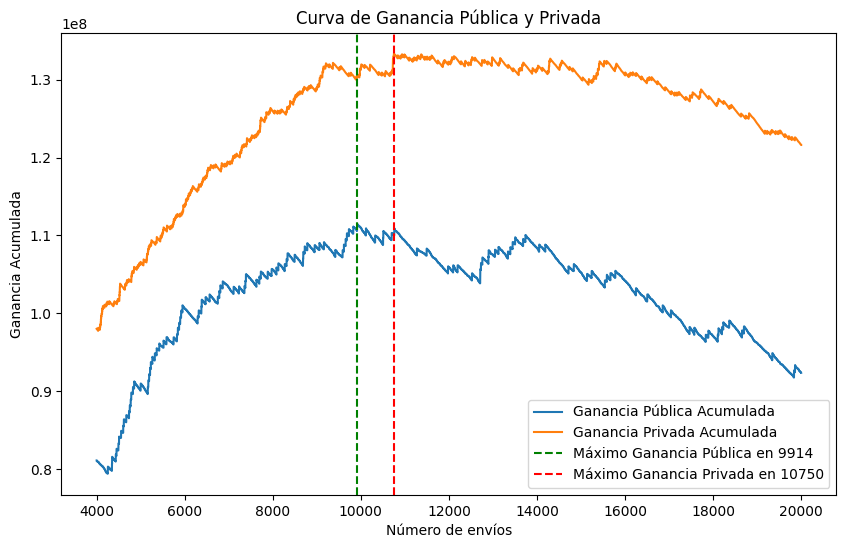

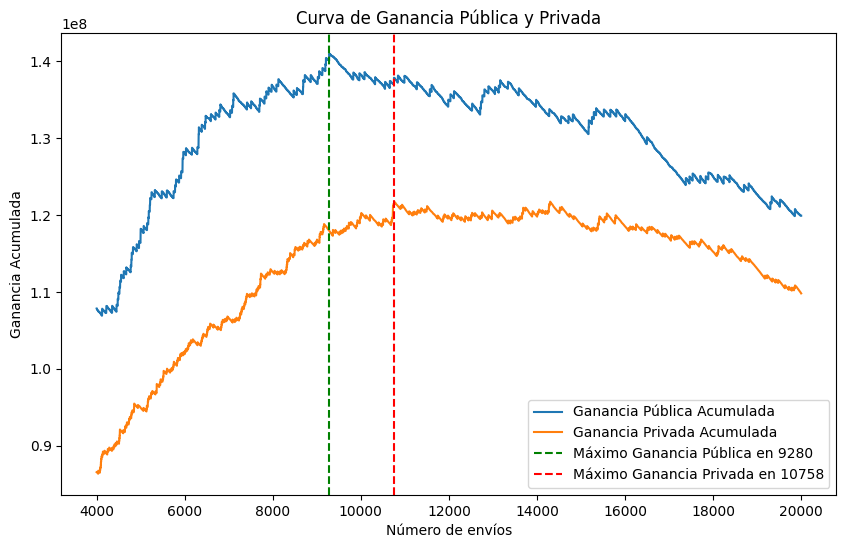

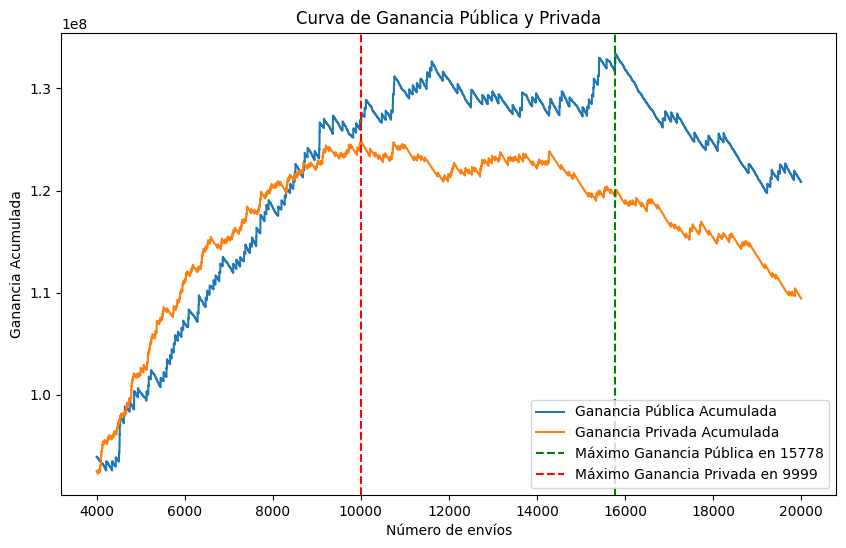

In [ ]:
def analisis_1(semilla):
  df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

  private_idx, public_idx = train_test_split(df_cut_point.index, test_size=0.3, random_state=semilla, stratify=y_test_binaria1)

  df_cut_point['public'] = 0.0
  df_cut_point['private'] = 0.0
  df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
  df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3

  df_cut_point['nro_envios'] = df_cut_point.reset_index().index

  df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
  df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

  plt.figure(figsize=(10, 6))
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['public_cum'][4000:20000], label='Ganancia Pública Acumulada')
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['private_cum'][4000:20000], label='Ganancia Privada Acumulada')

  max_public_cum = df_cut_point['public_cum'][4000:20000].max()
  max_public_idx = df_cut_point['public_cum'][4000:20000].idxmax()
  plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

  max_private_cum = df_cut_point['private_cum'][4000:20000].max()
  max_private_idx = df_cut_point['private_cum'][4000:20000].idxmax()
  plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

  plt.title('Curva de Ganancia Pública y Privada')
  plt.xlabel('Número de envíos')
  plt.ylabel('Ganancia Acumulada')
  plt.legend()
  plt.show()

analisis_1(semillas[0])
analisis_1(semillas[1])
analisis_1(semillas[2])
analisis_1(semillas[3])


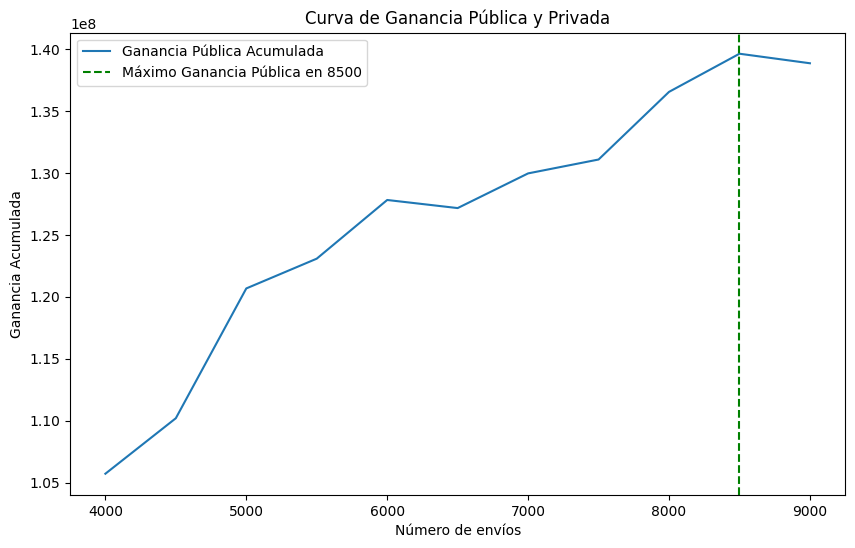

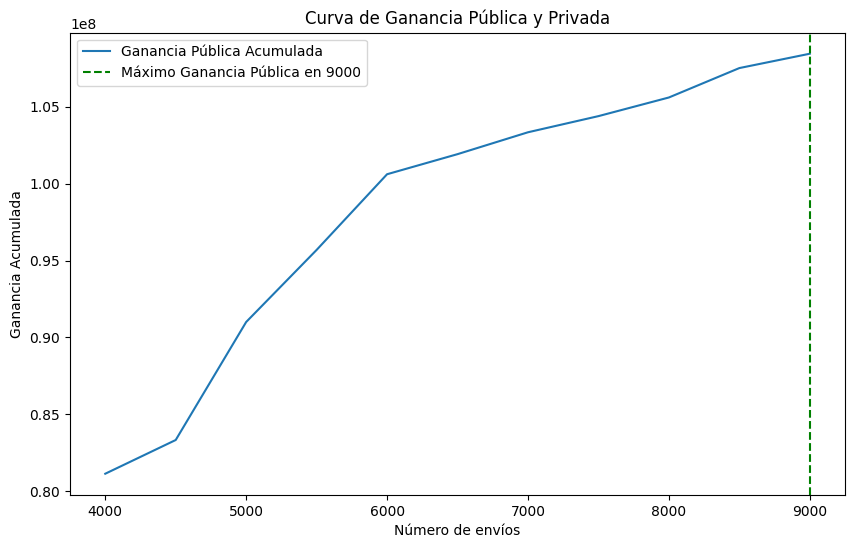

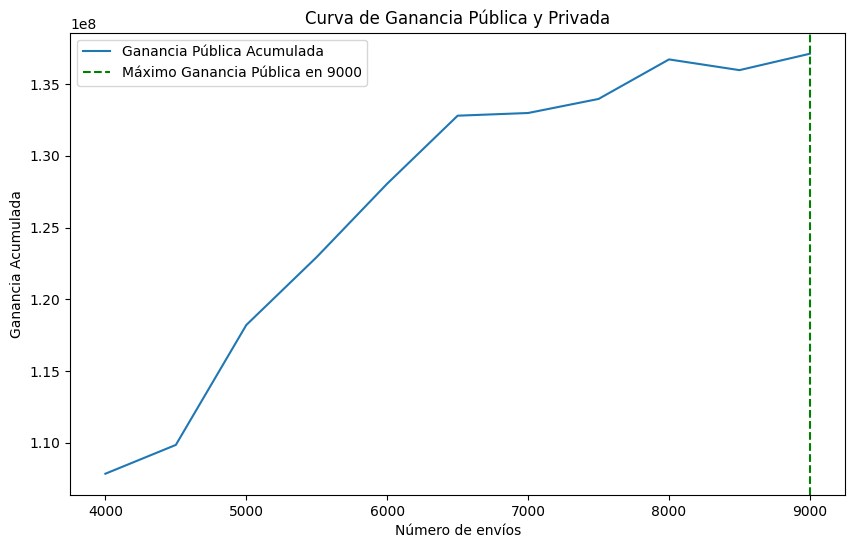

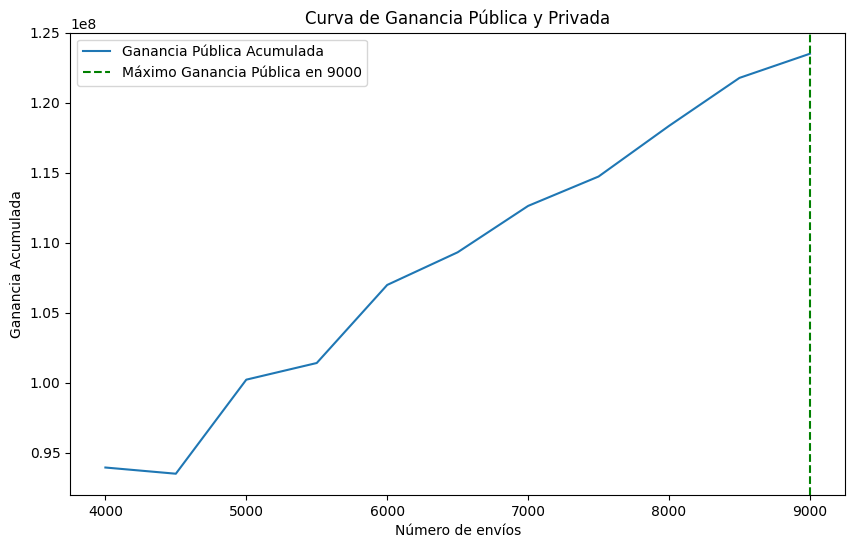

In [ ]:
def analisis_2(semilla, desde, paso, cantidad, private = False):

  df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})
  df_cut_point['nro_envios'] = df_cut_point.reset_index().index

  plt.figure(figsize=(10, 6))

  private_idx, public_idx = train_test_split(df_cut_point.index, test_size=0.3, random_state=semilla, stratify=y_test_binaria1)

  df_cut_point['public'] = 0.0
  df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3
  df_cut_point['public_cum'] = df_cut_point['public'].cumsum()

  maximo_paso = desde + paso*cantidad
  plt.plot(df_cut_point['nro_envios'][list(range(desde, maximo_paso + 1, paso))], df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))], label='Ganancia Pública Acumulada')
  max_public_cum = df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))].max()
  max_public_idx = df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))].idxmax()
  plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

  if private:
    df_cut_point['private'] = 0.0
    df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
    df_cut_point['private_cum'] = df_cut_point['private'].cumsum()
    plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['private_cum'][4000:20000], label='Ganancia Privada Acumulada')
    max_private_cum = df_cut_point['private_cum'][4000:20000].max()
    max_private_idx = df_cut_point['private_cum'][4000:20000].idxmax()
    plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

  plt.title('Curva de Ganancia Pública y Privada')
  plt.xlabel('Número de envíos')
  plt.ylabel('Ganancia Acumulada')
  plt.legend()
  plt.show()

analisis_2(semillas[0], 4000, 500, 10, private=False)
analisis_2(semillas[1], 4000, 500, 10, private=False)
analisis_2(semillas[2], 4000, 500, 10, private=False)
analisis_2(semillas[3], 4000, 500, 10, private=False)

## Tarea:

1. **Generar Dataset**  
   - Utilice las técnicas de *feature engineering* vistas en las clases anteriores para generar un nuevo conjunto de datos.
   
2. **Optimización de LightGBM (LGBM)**  
   - Ajuste el modelo de LightGBM utilizando una mayor cantidad de árboles y realice una exploración más exhaustiva de los hiperparámetros para mejorar su rendimiento.
   
3. **Incluir Nuevos Parámetros en la Optimización**  
   - Revise la documentación de los parámetros de LightGBM. Evalúe la inclusión de otros parámetros en el proceso de optimización, y ajuste el modelo con estos nuevos parámetros.
   
4. **Selección del Mejor Modelo**  
   - Entre los cinco mejores modelos obtenidos en cada optimización, seleccione el que considere más adecuado para la competencia en Kaggle.
   - Documente las pruebas que realizó para seleccionar el mejor modelo. Justifique su decisión con métricas relevantes y análisis comparativos.
5. Escriba y comparta por **Zulip** una función que envíe prepare el dataset que es necesario enviar a **kaggle** con los N clientes con mayor probabilidad.

# Envios

In [ ]:
X_result = data[data['foto_mes'] == mes_score]
X_result = X_result.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

In [ ]:
pip install kaggle


In [ ]:
import kaggle


In [ ]:
competition_name = 'dm-ey-f-2024-primera'  # Reemplaza con el nombre de tu competencia

models_list = [model_first_best, model_second_best, model_third_best, model_fourth_best, model_fifth_best]

for index, model_trial in enumerate(models_list):

  probas_baja2 = model_trial.predict(X_result)

  predicted = np.zeros(len(probas_baja2))

  # Obtener los índices de los 11000 clientes con mayor probabilidad de ser BAJA+2
  top_11000_indices = np.argsort(probas_baja2)[-11000:]

  # Asignar 1 en la columna 'Predicted' a esos 11000 clientes
  predicted[top_11000_indices] = 1
  predicted = predicted.astype(int)

  # Crear el nuevo DataFrame con las columnas 'numero_de_cliente' y 'Predicted'
  df_estimulo = pd.DataFrame({
      'numero_de_cliente': X_result['numero_de_cliente'],  # Asegúrate de que X_result tenga la columna 'numero_de_cliente'
      'Predicted': predicted
  })

  #Envio a kaggle
  df_estimulo.to_csv(resultados_path + f'df_estimulo_603_{index+1}.csv', index=False)

  # Configuración
  file_path = resultados_path + f'df_estimulo_603_{index+1}.csv'  # Ruta al archivo que deseas enviar

  # queda comentado el envio a kaggle
  # Enviar el archivo a la competencia
  # kaggle.api.competition_submit(file_path, f'Estudio 603 - Modelo {index+1} - feat eng, elimino variables con mala quali, deciles y deciles change, entreno 02', competition_name)
  # print("Envío completado.")




100%|██████████| 1.93M/1.93M [00:00<00:00, 6.76MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 6.92MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 7.08MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 6.64MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 6.75MB/s]


Envío completado.


In [ ]:
competition_name = 'dm-ey-f-2024-primera'  # Reemplaza con el nombre de tu competencia

models_list = [model_first_best_final, model_second_best_final, model_third_best_final, model_fourth_best_final, model_fifth_best_final]

for index, model_trial in enumerate(models_list):

  probas_baja2 = model_trial.predict(X_result)

  predicted = np.zeros(len(probas_baja2))

  # Obtener los índices de los 11000 clientes con mayor probabilidad de ser BAJA+2
  top_11000_indices = np.argsort(probas_baja2)[-11000:]

  # Asignar 1 en la columna 'Predicted' a esos 11000 clientes
  predicted[top_11000_indices] = 1
  predicted = predicted.astype(int)

  # Crear el nuevo DataFrame con las columnas 'numero_de_cliente' y 'Predicted'
  df_estimulo = pd.DataFrame({
      'numero_de_cliente': X_result['numero_de_cliente'],  # Asegúrate de que X_result tenga la columna 'numero_de_cliente'
      'Predicted': predicted
  })

  #Envio a kaggle
  df_estimulo.to_csv(resultados_path + f'df_estimulo_603_final_{index+1}.csv', index=False)

  # Configuración
  file_path = resultados_path + f'df_estimulo_603_final_{index+1}.csv'  # Ruta al archivo que deseas enviar
  # queda comentado el envio a kaggle
  # Enviar el archivo a la competencia
  # kaggle.api.competition_submit(file_path, f'Estudio 603 - Modelo {index+1} - feat eng, elimino variables con mala quali, deciles y deciles change, entreno 02, 03, 04', competition_name)
  # print("Envío completado.")

100%|██████████| 1.93M/1.93M [00:00<00:00, 7.19MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 6.79MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 7.21MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 6.29MB/s]


Envío completado.


100%|██████████| 1.93M/1.93M [00:00<00:00, 7.05MB/s]


Envío completado.
